In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import tqdm

加载数据

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST('../dataset/', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST('../dataset/', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

输入形状 $n_h\times n_w$  
卷积核形状 $k_h\times k_w$  
填充 $p_h \times p_w$  
输出形状 $(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$  
通常设置 $p_h=k_h-1$, $p_w=k_w-1$
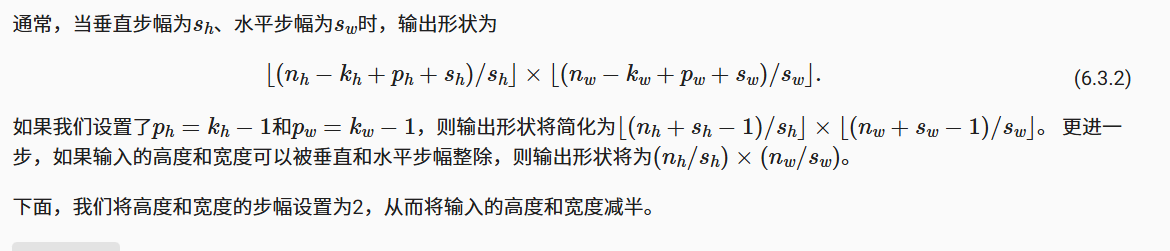

In [3]:
class net(torch.nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.nn_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            torch.nn.Sigmoid(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5, padding=1),
            torch.nn.Sigmoid(),
            torch.nn.AvgPool2d(kernel_size=2, padding=1),
        )
        self.nn_2 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(16*7*7, 120),
            torch.nn.Sigmoid(),
            torch.nn.Linear(120, 10)
        )

    def forward(self, x):
        x = self.nn_1(x)
        x = self.nn_2(x)
        return x

In [4]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [5]:
model = net()
model = model.to(device=try_gpu())

# 定义优化器和损失函数
optimizer = torch.optim.SGD(model.parameters(), lr = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # 更新学习率

model.train()
epochs= 5

Loss_data = {
    "train": [],
    "dev": []
}

acc_data = {
    "train": [],
    "dev": []
}

# 训练
for epoch in range(epochs):
    Loss = 0
    with tqdm.tqdm(total=trainloader.__len__()) as pbar:
        model.train()
        running_train_loss = 0.0
        for batch_x, batch_y in trainloader:
            x, y = batch_x.to(device=try_gpu()), batch_y.to(device=try_gpu())
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pbar.update(1)
            running_train_loss += loss.item()
        
        scheduler.step()
        
        # 训练损失
        epoch_train_loss = running_train_loss / len(trainloader)
        model.eval()
        Loss_data["train"].append(epoch_train_loss)

        # 测试损失
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in testloader:
                x, y = inputs.to(device=try_gpu()), targets.to(device=try_gpu())
                outputs = model(x)
                loss = criterion(outputs, y)
                running_test_loss += loss.item()
        epoch_test_loss = running_test_loss / len(testloader)
        Loss_data["dev"].append(epoch_test_loss)

        i = 0
        accuracy_sum = 0
        for images, labels in testloader:
            images = images.to(device=try_gpu())
            labels = labels.to(device=try_gpu())
            y_predict = model(images)
            y_predict = torch.argmax(y_predict, dim = 1)
            accuracy = torch.eq(labels, y_predict).float().mean()
            accuracy_sum = accuracy_sum + accuracy.item()
            i = i + 1
        acc_data["dev"].append(accuracy_sum / i)

        i = 0
        accuracy_sum = 0
        for images, labels in trainloader:
            images = images.to(device=try_gpu())
            labels = labels.to(device=try_gpu())
            y_predict = model(images)
            y_predict = torch.argmax(y_predict, dim = 1)
            accuracy = torch.eq(labels, y_predict).float().mean()
            accuracy_sum = accuracy_sum + accuracy.item()
            i = i + 1
        acc_data["train"].append(accuracy_sum / i)


100%|██████████| 938/938 [00:54<00:00, 17.11it/s]


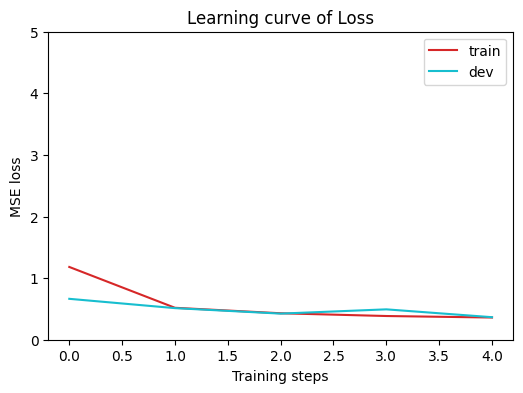

In [8]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = [i for i in range(len(loss_record['train']))]
    x_2 = [i for i in range(len(Loss_data["dev"]))]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_learning_curve(Loss_data, "Loss")

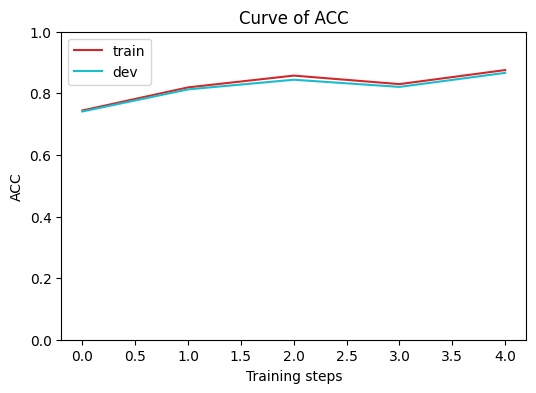

In [13]:
def plot_acc_curve(acc_record, title=''):
    x_1 = [i for i in range(len(acc_record['train']))]
    x_2 = [i for i in range(len(acc_record["dev"]))]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, acc_record['train'] , c='tab:red', label='train')
    plt.plot(x_2, acc_record['dev'] , c='tab:cyan', label='dev')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('ACC')
    plt.title('Curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_acc_curve(acc_data, "ACC")